# Data Cleaning: Coreset vs Random

## Purpose
The purpose of this example is to demonstrate how the DataHeroes' dataheroes library can be used to help you clean your data by easily identifying and fixing incorrectly labeled data as well as identifying other anomalies in your dataset such as data imbalance and under-represented domains. The library uses a methodology from computational geometry known as coresets to compute the importance of each data instance in your dataset, or how much this instance can affect your model. Individual instances with high importance usually indicate a labeling error or other anomaly or outlier.
In this example, we’re using the credit card fraud detection dataset. We then introduce noise to this dataset, by mislabeling some of the data instances of the train dataset. In the next step, we compare two cleaning methods, cleaning the data using coresets and cleaning the data using random sampling. Cleaning the data using coresets is simple and requires only a few lines of code. We first instantiate the CoresetTreeServiceDTC class while optimized_for='cleaning' and build the Coreset service tree using the build function. Then in each cleaning iteration, we call the get_cleaning_samples function, to retrieve samples that have high importance, which usually indicates a labeling error or other anomaly, from the classes we are interested in. In each iteration we also call update_targets to update the labels of the mislabeled samples. Finally, we have a couple of plots comparing the cleaning results of both methods, using coresets and randomly. As can be seen, using coresets, we were able to identify many, many more mislabeled instances in our dataset, which make coresets a great way to clean data. The same methodology can be easily applied to your dataset too.


In [1]:
import copy
import pathlib
import warnings
import gdown

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from dataheroes import CoresetTreeServiceDTC 

## Load Credit Card Fraud Dataset
To view more information about the dataset please refer to the next <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud"> link  </a>

In [2]:
# public folder on Google drive with data
url = "https://drive.google.com/drive/folders/1x7wSSs3P195Cu4VtylhqHOypwSKQg1OA?usp=sharing"
# create local data folder
data_path = pathlib.Path('../data/credit_card_fraud_detection/generated')
data_path.mkdir(parents=True, exist_ok=True)
# download files
if not (data_path / 'creditcard.csv').exists():
    gdown.download_folder(url, quiet=True, use_cookies=False, output=str(data_path))

# load data to the memory
data = pd.read_csv(data_path / 'creditcard.csv')

In [3]:
X = data.drop('Class', axis=1)  
y = data['Class']  

# Split the data into train and test sets while stratifying based on the 'Class' column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Calculate the fraud rate in the training and test sets
fraud_rate_train = y_train.mean()
fraud_rate_test = y_test.mean()

#We check if the fraud rate is similar in the training and test sets
print("Fraud Rate in Training Set:", fraud_rate_train)
print("Fraud Rate in Test Set:", fraud_rate_test)

#Convert to numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


Fraud Rate in Training Set: 0.0017274876524425926
Fraud Rate in Test Set: 0.0017274795651807534


## Initialize an XGBoost classifier
We've set n_estimators to 300 to get better convergence. 


In [4]:
clf_params = {'objective': 'binary:logistic', 'n_estimators': 300,'tree_method':'hist'}
clf = XGBClassifier(**clf_params)

## Define the evaluation method

In [5]:
def eval_clf(y_train_to_eval):
    clf.fit(X_train, y_train_to_eval)
    proba = clf.predict_proba(X_test)[:, 1]
    precision = average_precision_score(y_test, proba)
    return precision 

## Evaluate model on the clean data

In [6]:
score_clean = eval_clf(y_train)

##  Randomly mislabeling data
We are randomly mislabeling data from class 1 to class 0

In [7]:
# Select indices of instances with class '1'
class_1_indices = np.where(y_train == 1)[0]

# Randomly select 80 indices from class '1' instances
selected_indices = np.random.choice(class_1_indices, size=80, replace=False)

# Make a copy of the original labels
y_train_noise_orig = copy.deepcopy(y_train)

# Mislabel those selected instances as '0'
y_train_noise_orig[selected_indices] = 0

## Evaluate before cleaning

In [8]:
score_before_cleaning = eval_clf(y_train_noise_orig)

## Fix labels simulation method

In [9]:
def fix_labels(y_train_to_fix, idxs):
    """In reality this is a manual procedure, but in this simulation, we know the correct and original label"""
    y_train_to_fix[idxs] = y_train[idxs]
    return y_train_to_fix

## Set cleaning params

In [10]:
n_iterations = 10
n_samples_per_iter = 100
# Define for the 0 class how many samples to fix in each iteration.
samples_per_class = {0: n_samples_per_iter}
print(f'{samples_per_class=}')

samples_per_class={0: 100}


## Clean data using the coreset service

In [11]:
coreset_result = {'score': [score_before_cleaning], 'fixed': [0], 'viewed': [0]}
y_train_noise = copy.deepcopy(y_train_noise_orig)
viewed_indices = np.array([]).astype(int)
dataset_indices = np.arange(0, len(X_train), dtype=int)

service = CoresetTreeServiceDTC (optimized_for='cleaning',n_instances=len(y_train_noise))
service.build(X_train, y_train_noise, indices=dataset_indices)

for i in range(n_iterations):
    # Returns indices of most important samples order by importance.
    result = service.get_cleaning_samples(
        class_size=samples_per_class,
    )
    
    important_samples = result['idx']
    y_train_noise = fix_labels(y_train_noise, important_samples)
    # Update the labels of the mislabeled samples in the Coreset tree
    service.update_targets(
        indices=important_samples,
        y=y_train_noise[important_samples],
    )

    viewed_indices = np.concatenate([viewed_indices, important_samples])
    score = eval_clf(y_train_noise)
    fixed = np.sum(y_train_noise != y_train_noise_orig)
    coreset_result['score'].append(score)
    coreset_result['fixed'].append(fixed)
    coreset_result['viewed'].append(len(viewed_indices))

## Clean data using random sampling

In [12]:
random_result = {'score': [score_before_cleaning], 'fixed': [0], 'viewed': [0]}
y_train_noise = copy.deepcopy(y_train_noise_orig)
viewed_indices = np.array([]).astype(int)
for i in range(n_iterations):
    for cls, amount in samples_per_class.items():
        rand_idxs = np.where(y_train_noise==cls)[0]
        rand_idxs = np.setdiff1d(rand_idxs, viewed_indices)
        np.random.shuffle(rand_idxs)
        rand_idxs = rand_idxs[:amount]
        y_train_noise = fix_labels(y_train_noise, rand_idxs)
        viewed_indices = np.concatenate([viewed_indices, rand_idxs])
    score = eval_clf(y_train_noise)
    fixed = np.sum(y_train_noise != y_train_noise_orig)
    random_result['score'].append(score)
    random_result['fixed'].append(fixed)
    random_result['viewed'].append(len(viewed_indices))

## Plot AUPRC chart

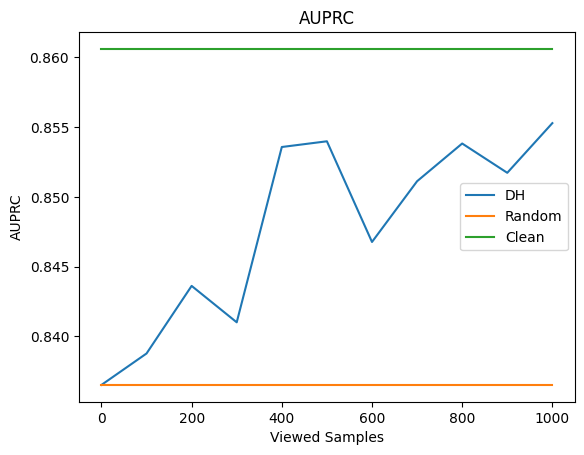

In [13]:
plt.plot(coreset_result["viewed"],coreset_result["score"], label="DH")
plt.plot(random_result["viewed"], random_result["score"],label="Random")
plt.plot(coreset_result["viewed"], np.ones(len(coreset_result["viewed"])) * score_clean, label="Clean")
plt.ylabel("AUPRC")
plt.xlabel("Viewed Samples")
plt.title("AUPRC")
plt.legend()
plt.show(block=False)

## Plot Fixed chart

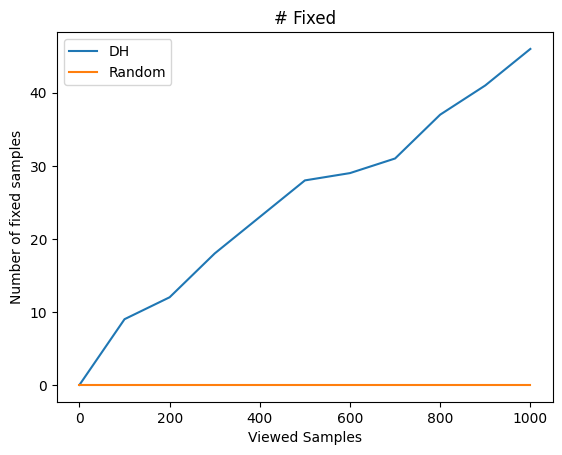

In [14]:
plt.plot(coreset_result["viewed"], coreset_result["fixed"], label="DH")
plt.plot(random_result["viewed"], random_result["fixed"], label="Random")
plt.ylabel("Number of fixed samples")
plt.xlabel("Viewed Samples")
plt.title("# Fixed")
plt.legend()
plt.show(block=False)